# **Reproducibility Project Blog: A Deep Learning-based Radar and CameraSensor Fusion Architecture for Object Detection**

Authors:

Yigen Zhong (yg.zhong@outlook.com)

Chenghao Xu (xuchenghao10@hotmail.com)

Contributions:

Yigen Zhong writes Section 1: Introduction, Section 3: The usage of github codes on nuScenes mini dataset, and the errorsolutions and the experimental results, Section 5: The cross projection method of radar data to images.

Chenghao Xu writes Section 1: Introduction, Section 2: The overview of CRF-NET with prior knowledge, Section 4: Hyperparameters check.

**加粗文字**# **1. Introduction**

In this blog, the paper "A Deep Learning-based Radar and Camera Sensor Fusion Architecture for Object Detection" will be introduced [1]. In 2020, Felix Nobis [1] published this article that proposed CameraRadarFusion Net (CRF-NET) to automatically learn the best sensor fusion level for object detection on extreme detect conditions, which builds upon the work of Keras RetinaNet. This neural network performs a multi-level fusion of the radar and camera data within the neural network. The state-of-the-art experiment performances are evaluated on the nuScenes dataset and the TUM dataset, which provide camera and radar data along with 3D ground truth information. As result, the fusion of radar and camera data in a neural network can augment the detection score of a state-of-the-art object detection network. Furthermore, this paper lends justification to a variety of areas for further exploration and research.

Recently, object detection using deep learning has greatly improved the detection rates and computationally efficient network structures, which makes this technique towards application in real production vehicles. Meanwhile, multi-sensor fusion is a comprehensive cutting-edge technology that has become the mainstream positioning solution for autonomous driving and robots. It involves a wide range and complexity, including sensor calibration, data processing, SLAM, and filtering. While human drivers conduct the driving mission via perception, it is convinced that autonomous automobiles are capable of autonomous driving activities with the help of cameras. However, only depending on the camera is not enough for guaranteeing the safety of driving because of bad weather and light conditions as shown in figure \ref{fig:lens}, while radar sensor has high robustness for these conditions. So more and more people are interested in how to fuse radar data and camera data in a deep learning network. Felix [1] proposed a fusion network architecture, which combines the neural networks based on the radar and camera sensor data. Object detection can be improved when coming across the adverse conditions like heavy rain or fog.

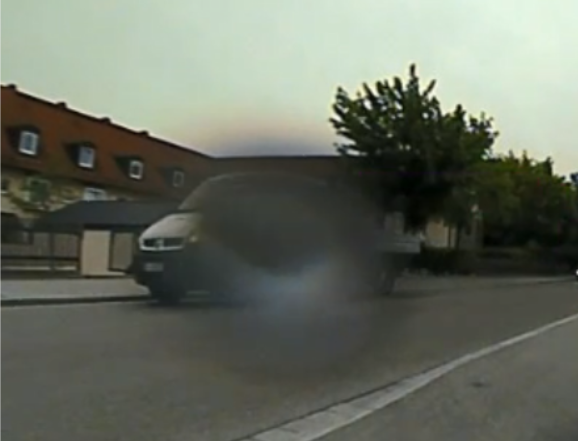

Figure 1. Water Droplet on the Lens[1]

In this blog, we will briefly introduce the prior knowledge needed and an overview of the whole process of CRF-NET . In section 3, the usage of GitHub code{The code is available at https://github.com/TUMFTM/CameraRadarFusionNet} and the solutions to the problems are illustrated. Besides, we will give the solution of how to work on the mini dataset of nuScenes dataset instead of the trainval full dataset and show the experimental results. Then, we will evaluate sensitivity to optimizers in section 4. Lastly, we will propose a new algorithm variant regarding the raw level fusion method for image and radar data in section 5, which improves the total mAP from 55.54\% to 56.45\% and decreases the standard derivation of mAP. We would like to learn about the deep learning applications on autonomous systems and explore the optimized network architectures for sensor fusion, which we believe could be generally applied and make great progress on actual production vehicles in future. 

## **# 3. The usage of github codes on nuScenes mini dataset, and the error solutions and the experimental results**

In this section, you will learn how to prepare the environment and use the repository on the mini nuScenes dataset instead of the trainval full dataset in the paper to train, evaluate and test. Here, we revise the code to solve an error of running the evaluation command on the mini dataset.

Before running the code, we need to look through the structure of the repository and have an overview of its functions. Most of the important files with README.md are located in the folder crfnet.

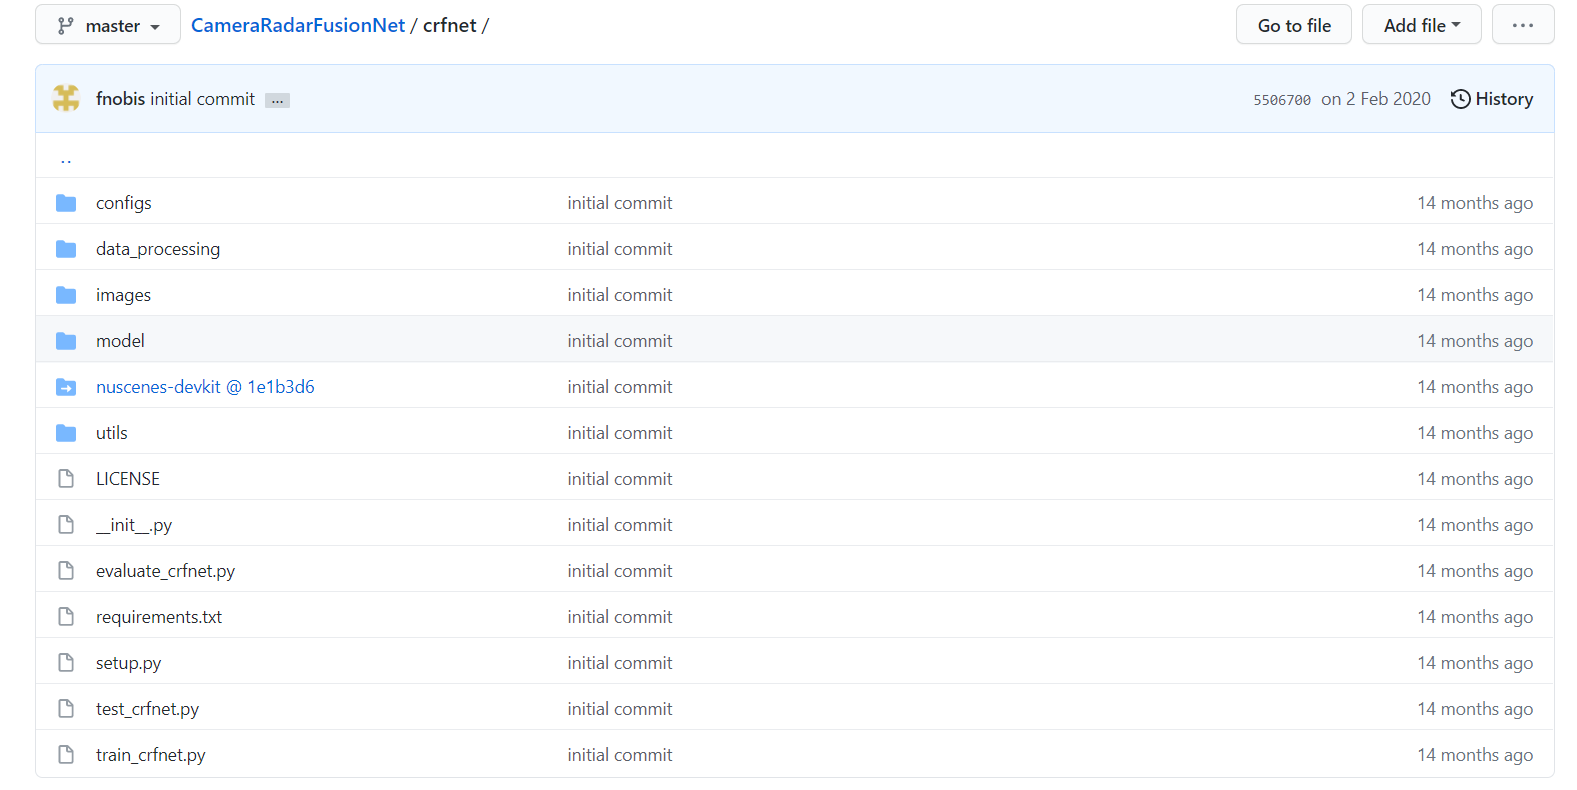

Figure 3. The structure of code repository.

The first file needed to look is README.md in the folder CamerRadarFusionNet. We need to check the Requirements firstly. It is a little difficult to manually install them on a local computer because of various possible errors. Our suggestion is to rent a cloud server which has been installed this software. Docker and NVIDIA Container are optional. Here, we rent a cloud server with a pre-installed software framework (TensorFlow 1.15.2 + Cuda10.0/cudnn7) and GPU Tesla T4. Before we go deep into it, you need to check the version of TensorFlow, Cuda, cudnn, python, GPU (these are the most important software).

For installation, firstly install system-wide packages (! is for jupyter running linux commands in cloud servers):

In [ ]:
!sudo apt install graphviz

Generally speaking, we will not encounter problems at this step. And then, run the command (This command is used to compare the packages in your system with CameraRadarFusionNet/crfnet/requirements.txt. If not, download the update):

In [ ]:
!pip install -e .

Although we have a pre-installed software framework, there are many possible errors. First of all, you need to check the version of all the packages needed, compared with CameraRadarFusionNet/crfnet/requirements.txt. Our successful TensorFlow version is 1.3.2. The most common error is the error "package incompatible". Sometimes the versions of the packages are too high or too low for the other packages. Please try to install the correct version, and then run this command again.


And then run the command (low possibility for error):

In [ ]:
!python setup.py build_ext -- inplace

Now, we have finished the Installation! Before training, we need to download the mini full nuScenes dataset (v1.0, 3.88GB) (https://www.nuscenes.org/download) instead of the trainval one because it is too big for normal people to train. We put and unzip the dataset in ./CameraRadarFusionNet/data/sets/nuscenes. And we do not use the pre-trained weights here.

And then, you can create configuration you want in ./CameraRadarFusionNet/crfnet/configs/crf\_net.cfg. Here, we mainly revise two parameters to find the dataset:

In [ ]:
data_set = nuscenes, mini
data_path = ./CameraRadarFusionNet/data/sets/nuscenes #path to your dataset

Here, if you obtain an Error, pls add the following code after importing required files in train\_crfnet.py (evaluate\_crfnet.py, test\_crfnet.py if necessary) to decrease TensorFlow 2.x to 1.x:

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

If everything is ok, you will get a pre-trained weights file ended in .h5 and an interface like Fig. \ref{fig:output}, which shows mAP, precision and recall indicators. Then, you should run the testing command without any error, which is used to test a trained CRF-Net model on the test set and output images with detection.

In [ ]:
!python test_crfnet.py --model saved_models/<your pretrained weights name>.h5 --config configs/crf_net.cfg - -st 0.5

Because the object classes in the mini dataset are fewer than that in the trainval dataset, when you run the evaluation command, you may meet the following type error:

Command:

In [ ]:
!python evaluate_crfnet.py --model saved_models/<your pretrained weights name>.h5 --config configs/crf_net.cfg --st 0.5


Error:

In [ ]:
Traceback (most recent call last): File "evaluate_crfnet.py", line 243, in <module> eval_data = np.stack(([label_name]*len(recalls[label]), recalls[label], precisions[label]))
TypeError: object of type 'int' has no len()

This error is caused by incorrectly outputting "int" type variable when there is an object class with a number of 0. Therefore, we offer a solution to force the type to be manually converted by adding the following code before the line "eval\_data= ..." in evaluate\_crfnet.py:

In [ ]:
if type(recalls[label])==int:
    recalls[label] = np.array([recalls[label]], dtype=float)
if type(precisions[label])==int:
    precisions[label] = np.array([precisions[label]], dtype=float)

We should run the training command without any error now. Let's start training!

In [ ]:
!python train_crfnet.py --config configs/crf_net.cfg

If everything is ok, you will obtain the following result:

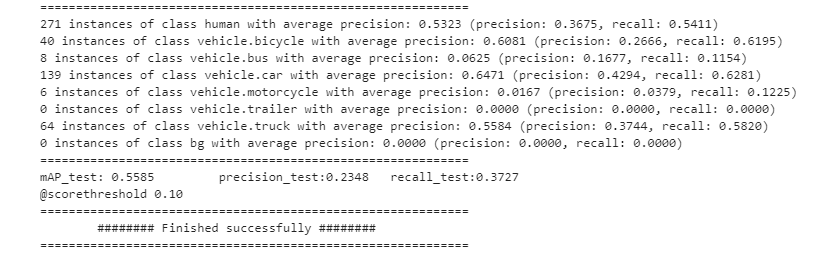

Figure 4. The training output without any parameter change.

You can also run the evaluating command and the testing command. The testing command's result is shown as follows:

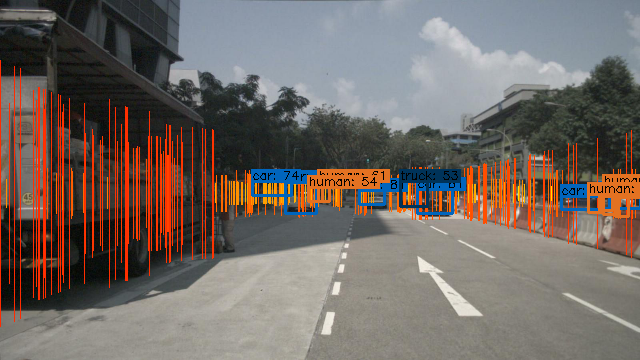

Figure 5. The visualization of detection by using the testing command.

# **5. The cross projection method of radar data to images**

**Background:** After reading the repository provided by [1], I have known that [1] fuses the image data and the radar data to create a new imageplus data. The original image with three channels is extended by adding the radar channels, where they actually use the distance and RCS radar channels as the additional channels of the image. And what they actually do is mapping the radar channels to the same locations of the image and creating a vertical line on them. As we can see in Fig 5, the locations of vertical lines in the image represent that there are embedded with the additional radar data. Because radar data is sparse, the rest of the image is embedded with Nan as the additional radar channels.

**Motivation:** This vertical projection method is great. However, I think there is room to improve. From an intuitive perspective, for an image, like Fig 5}, humans should detect the objects more easily on the image, where the objects are properly attached with the salient vertical, line than the pure one. But for an object classification task, I begin to think the cross projection method may show a better performance than the vertical one because the cross projection may make machines more focused on objects, compared to the vertical projection. For example, a lot of players prefer crosshairs to play shooting games because it is great for locating targets and provides the most intuitive horizontal and vertical reference. Moreover, a human driver (e.g. me) pays attention to a certain height during driving. This is because the center of most objects is located at a certain height. If we want to determine an object surrounded by a box, determining the center and the width will be useful. This is like a heuristic method that encourages the detector to focus on these areas referred to by the crosshairs. Therefore, I believe the cross projection method can perform better than the vertical projection method in this sensor fusion scene.

**Solution:** The basic idea of the cross projection method is to add a horizontal line with the same radar information on the vertical line at the appropriate height. 

The code is provided as fusion_projection_lines_cross_projection.py.

Our repository: https://github.com/EganZhong/Reproducibility-project-of-Deep-learning.git

**Experiments & Analysis:** Up to now, the hyperparameters of cross projection are the height of the vertical line, the width, and the height of the horizontal line. In order to control the number of experimental variables, I mostly focus on the width of the horizontal line, partly on the height of it, and I use the default height of the vertical line $3m$ in \cite{Felix}. Thus, I set up the following experimental variables in my first set experiment: the height of the vertical line $h_v = 3m$, the height of the horizontal line $h_h = 1.5m$, the width of the horizontal line $w_h = 0*h_v, 0.1*h_v, 0.167*h_v, 0.25*h_v, 0.5*h_v, 0.8*h_v, 1*h_v$. For the total mAP, I have done 20 experiments for each set of $w_h$ variables, except for $w_h = 0.8*h_v$ (only 10 times) because of the randomness of the neural network, and I take their mAP and standard deviation (std) as the indicators of performance and robustness. Apart from these parameters, the other parameters are default. The box plot, the mean line chart, and the std line chart are shown as follows:

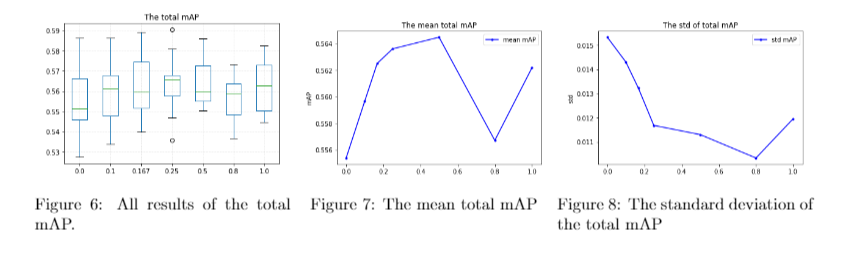

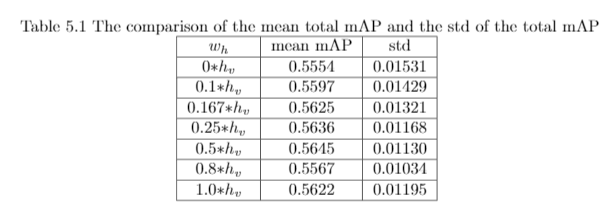

During training, I notice that the test results of those experimental variables tend to be bad and unstable during the first few training sessions because I often reconstruct my model on a new server. I think this is because the training model does not adapt to the dataset, and the results are not normalized and stable. I assume the model needs to train few times to adjust its internal hyperparameters on a new machine. Thus, my experimental results come from the results after a few epochs on a new machine. 

As we can see in Fig. 6 - 8, as long as we using the cross projection method, there is an improvement for mAP and prediction stability. The mean total mAP of $w_h=0.25*h_v$ and $w_h=0.5*h_v$ are $0.5636$ and $0.5645$, comparing with the original one $w_h=0*h_v$($0.5554$). At the same time, the std of total mAP of $w_h=0.25*h_v$ and $w_h=0.5*h_v$ are $0.0117$ and $0.0113$, comparing with the original one $w_h=0*h_v$($0.01531$). Generally, this indicates that the cross projection method does have a potentially better performance than the vertical one. However, during the experiment, I find that the performance is worse when $v_h$ is divided by a pure multiple of three. I do not really know the reason, but I guess it may be relevant to the width-to-height ratio and the radar cross section of objects, such as humans and cars. Moreover, notice that $w_h=0.8*h_v$ does not perform well, comparing with the others variables. 

Therefore, I also analyze the impact of the cross projection method on the different classes of objects. The following experimental results come from ten of the above twenty experiments.

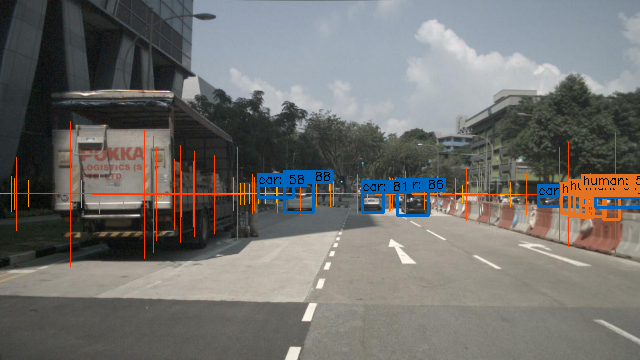

Figure 9: The visualization of detection by using the cross projection method.

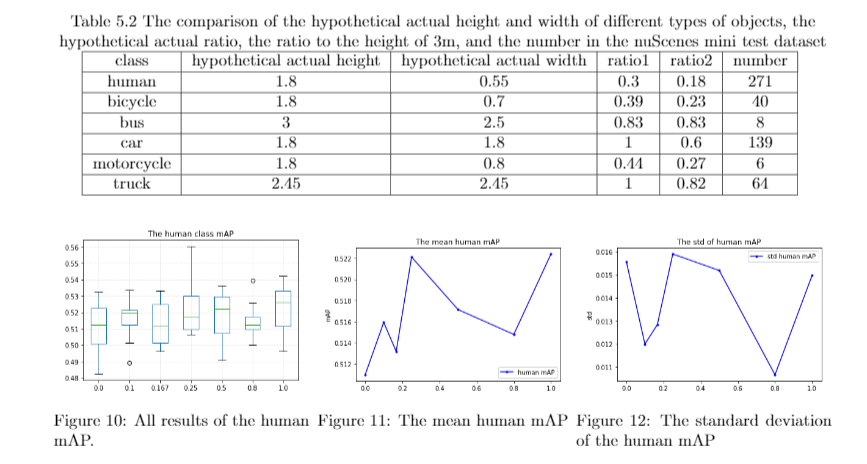

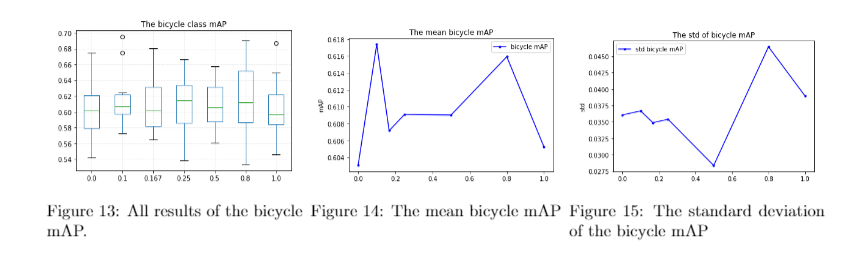

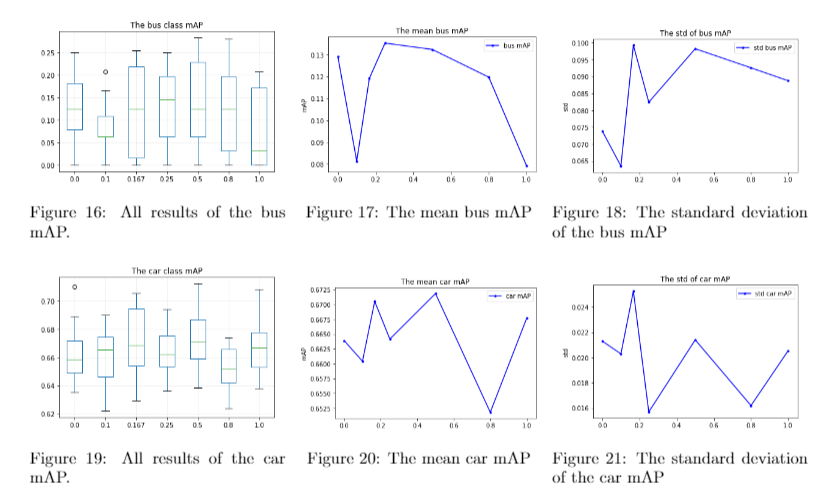

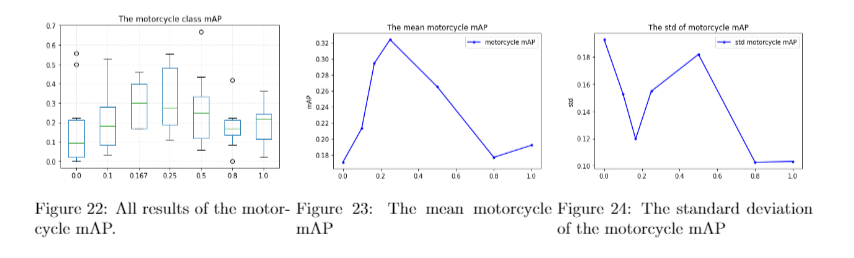

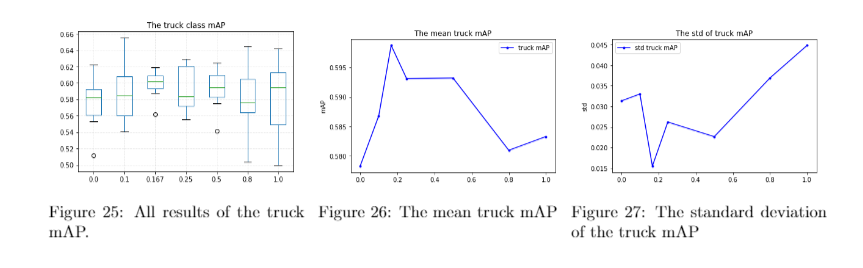

According to Table 5.2, I notice that the proportions of different objects are very different, where humans and cars are the main components, while buses and trucks have the least proportion. For the most classes of objects, their best $w_h$ are located at the range $[0.1 \sim 0.5]*h_v$. But most of them do improve mAP, while std does not have a very obvious pattern for a single category, but the total std does have decreased. As a matter of fact, I have no way to clearly summarize what kind of value is the most suitable for each category of objects, because they seem to have their own most suitable $w_h$. There is no obvious direct connection with the width-to-height ratio. Perhaps this is the combined effect of the width-to-height ratio and the radar section cross. 

Furthermore, I also try tried a little bit to learn from the idea of bagging to value each crosshair's $w_h$ according to the value of radar cross section because each category has a different radar cross section value. But it works worse than simply value $w_h=0.5*h_v$. Besides, I also try to place the horizontal line one fourth of the height of the vertical line. But it also works worse than placing it half the height of the vertical line.

**Conclusion:** For the cross projection method, we do see the improvement of mAP and prediction stability. However, there are still many places where there is no clear explanation. I get several assumptions about why this method works. Firstly, it does provide a horizontal and vertical reference for the training network, making it easier for the network to distinguish the target object. Or, it plays a role in increasing the density of radar data because radar data is relatively sparse. Or, these two assumptions both work. On the contrary, these experimental results do not indicate the effectiveness of the cross project method, because the improvement of performance may have randomness. For example, not enough experiments were done, or the epoch or the dataset is not big enough. Apart from the effectiveness of this method, it should notice that the $w_h$ is not the bigger the better. This is because when the horizontal line is too long, the radar information of the old horizontal line will be covered by the radar information of the new horizontal line nearby, please see Fig 9. This may introduce too much confusing information. These all need further research and more experiments. However, it may provide a new and interesting direction on how to fuse radar data and image data.